# Project Echo - Experiment Benchmarking Framework

This notebook provides an interactive interface to the benchmarking framework. It allows you to run various experiments with different model architectures and augmentation strategies, and compare their performance.

## Overview

The benchmarking framework is designed to systematically evaluate different combinations of:
- Model architectures (EfficientNet, MobileNet, ResNet, etc.)
- Audio augmentation strategies
- Image/spectrogram augmentation strategies

Results are collected and visualised to help identify the best performing configurations for bird sound classification.

## Hardware and Software Requirements

### Hardware Requirements

**Minimum Requirements:** (A 100 Epoch training cycle should take under 30 minutes with the minimum configuration, if GPU accellaration is enabled. It will take 12+ hours running on CPU)
- **CPU**: Intel i5 or AMD Ryzen 5 (4+ cores recommended)
- **RAM**: 16 GB minimum (32 GB recommended for large datasets)
- **Storage**: 50 GB free space for datasets, models, and cache
- **GPU**: NVIDIA GPU with 8 GB VRAM minimum (required for GPU acceleration)
  - Recommended: NVIDIA RTX 3080/4080 or better
  - Minimum: NVIDIA GTX 1080 or RTX 2060
  - Must support CUDA Compute Capability 6.0 or higher

**Recommended Configuration:** (A 100 Epoch training cycle should take under 10 minutes on this configuration)
- **CPU**: Intel i7/i9 or AMD Ryzen 7/9 (8+ cores)
- **RAM**: 32 GB or more
- **Storage**: 100+ GB SSD storage
- **GPU**: NVIDIA RTX 3090/4090 with 24 GB VRAM for optimal performance


**Cloud Service Providers**
This program required some pretty heavy hardware. As this notebook runs in a devcontainer, a docker file can be created from the devcontainer.json and setup.sh files and used to start an instance on a cloud service provider. I recommend vast.ai as a cloud service provider due to the availability of RTX 3900 and 4900 series gpus for training. 

### Software Requirements

**Operating System:**
- Windows 10/11 with WSL2 enabled (using docker)
- Linux (Ubuntu 20.04+ recommended) (using docker)
- macOS (CPU-only, limited GPU support)

**Required Software:**
- **Docker Desktop** with WSL2 integration (for devcontainer support)
- **Visual Studio Code** with Dev Containers extension
- **NVIDIA Docker runtime** (nvidia-docker2) for GPU support in containers
- **CUDA Drivers** 11.8 or compatible (installed on host system)

**Development Environment:**
- This project uses a **devcontainer** for consistent development environment
- All Python dependencies and CUDA libraries are pre-configured in the container
- No manual Python/TensorFlow installation required on host system

**Setup Prerequisites (Host System Setup):**
1. **Ensure NVIDIA drivers are up to date on host system** (CUDA 11.8+ compatible)
2. **Install Docker Desktop with WSL2 backend** (This should already be done in the induction task)
3. **Install NVIDIA Docker runtime for GPU passthrough (HOST SYSTEM):**
   - **For Ubuntu/Linux:**
     ```bash
     # Add NVIDIA Docker repository
     distribution=$(. /etc/os-release;echo $ID$VERSION_ID)
     curl -s -L https://nvidia.github.io/nvidia-docker/gpgkey | sudo apt-key add -
     curl -s -L https://nvidia.github.io/nvidia-docker/$distribution/nvidia-docker.list | sudo tee /etc/apt/sources.list.d/nvidia-docker.list
     
     # Update package list and install
     sudo apt-get update
     sudo apt-get install -y nvidia-docker2
     
     # Restart Docker daemon
     sudo systemctl restart docker
     ```
   - **For Windows with WSL2:**
     ```bash
     # In WSL2 Ubuntu distribution (on host):
     # First ensure NVIDIA drivers are installed on Windows host
     # Then install nvidia-docker2 in WSL2 as above
     
     # Add NVIDIA Docker repository in WSL2
     distribution=$(. /etc/os-release;echo $ID$VERSION_ID)
     curl -s -L https://nvidia.github.io/nvidia-docker/gpgkey | sudo apt-key add -
     curl -s -L https://nvidia.github.io/nvidia-docker/$distribution/nvidia-docker.list | sudo tee /etc/apt/sources.list.d/nvidia-docker.list
     
     sudo apt-get update
     sudo apt-get install -y nvidia-docker2
     sudo systemctl restart docker
     ```
4. **Install VS Code with Dev Containers extension**
5. **Clone repository and open in VS Code**
6. **Select "Reopen in Container" when prompted** (this builds the devcontainer)

**After Devcontainer is Built - Test GPU Access (INSIDE CONTAINER):**
Open VS Code terminal (inside the devcontainer) and run:
```bash
# Verify GPU access inside the container
nvidia-smi
# Should display GPU information if passthrough is working

# Test TensorFlow GPU detection
python -c "import tensorflow as tf; print('GPUs Available:', tf.config.list_physical_devices('GPU'))"
# Should show available GPUs
```

**Network Requirements:**
- Internet connection for downloading models and datasets
- Sufficient bandwidth for large audio dataset downloads

### Dataset Setup

**Audio Data Folder Structure:**
Ensure your audio files are in a folder in the workspace called "Audio_data" (case sensitive). The files need to be organised in individually labelled folders, where each folder name represents a class/species. 

**Example folder structure:**
```
/workspace/
├── Audio_data/
│   ├── Acanthiza_chrysorrhoa/
│   │   ├── audio_file_1.wav
│   │   ├── audio_file_2.mp3
│   │   └── audio_file_3.flac
│   ├── Acanthiza_lineata/
│   │   ├── recording_001.wav
│   │   ├── recording_002.ogg
│   │   └── recording_003.wav
│   ├── Corvus_mellori/
│   │   ├── crow_call_1.wav
│   │   ├── crow_call_2.wav
│   │   └── crow_call_3.mp3
│   └── Falco_peregrinus/
│       ├── falcon_1.wav
│       ├── falcon_2.flac
│       └── falcon_3.wav
├── config/
├── utils/
└── Benchmarking_Framework.ipynb
```

**Important Notes:**
- **Folder names** become the **class labels** for training
- Use consistent naming (e.g., scientific names, common names)
- **Supported audio formats**: .wav, .mp3, .flac, .ogg
- **Minimum files per class**: At least 3-5 files recommended
- **File naming**: Can be anything, only folder names matter for classification
- **No spaces**: Use underscores or hyphens in folder names (e.g., "Blue_Jay" not "Blue Jay")

## TensorBoard Integration

This benchmarking framework includes comprehensive **TensorBoard support** for monitoring training progress and analysing model performance. TensorBoard logs are automatically generated during experiment execution and saved to the `tensorboard_logs/` directory.

### What TensorBoard Provides

**Training Metrics:**
- Real-time loss and accuracy tracking during training
- Learning rate schedules and optimiser behaviour
- Training vs validation performance comparison
- Epoch-by-epoch progress visualisation

**Model Architecture:**
- Interactive model graph visualisation
- Layer-by-layer parameter counts
- Model complexity analysis

**Performance Analysis:**
- Confusion matrix heatmaps
- Per-class accuracy breakdowns
- Precision, recall, and F1-score tracking
- Training time and resource utilisation

### TensorBoard Directory Structure

The framework organises TensorBoard logs by experiment:
```
tensorboard_logs/
├── experiment_name_timestamp/
│   ├── train/
│   │   ├── events.out.tfevents...
│   │   └── plugins/
│   └── validation/
│       ├── events.out.tfevents...
│       └── plugins/
└── another_experiment_timestamp/
    ├── train/
    └── validation/
```

### Running TensorBoard

**Method 1: Terminal Command (Recommended)**
Open a terminal in VS Code and run:
```bash
# Launch TensorBoard for all experiments
tensorboard --logdir=tensorboard_logs --host=0.0.0.0 --port=6006

# Launch TensorBoard for a specific experiment
tensorboard --logdir=tensorboard_logs/experiment_name_timestamp --host=0.0.0.0 --port=6006

# Launch with custom port (if 6006 is in use)
tensorboard --logdir=tensorboard_logs --host=0.0.0.0 --port=6007
```

### Accessing TensorBoard

**In Development Environment:**
1. Run the tensorboard command above
2. Open your browser to: `http://localhost:6006`
3. Navigate between different experiments using the dropdown

**In Cloud/Remote Environment (e.g., Vast.ai):**
1. Run tensorboard with `--host=0.0.0.0`
2. Access via: `http://[your-instance-ip]:6006`
3. Ensure port 6006 is exposed in your cloud configuration

**In VS Code (Alternative):**
- Use VS Code's "Simple Browser" extension
- Open Command Palette (Ctrl+Shift+P)
- Type "Simple Browser" and enter `http://localhost:6006`

### TensorBoard Tips

**Performance Monitoring:**
- Monitor validation loss to detect overfitting
- Compare training curves between different experiments
- Use the "Scalars" tab for metric trends

**Model Comparison:**
- Run multiple experiments to compare architectures
- Use TensorBoard's run comparison features
- Filter experiments by tags or names

**Debugging:**
- Check gradient histograms for training issues
- Monitor learning rate schedules
- Analyse layer activations in the "Histograms" tab

**Best Practices:**
- Keep TensorBoard running during long training sessions
- Use meaningful experiment names for easy identification
- Regularly save TensorBoard logs for future reference## 1. Import Required Libraries

In [16]:
# Consolidated Imports
# This cell imports all required libraries for the benchmarking framework.
# All dependencies are centralised here for better organisation.
# No backend files - these are standard library imports.

import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from ipywidgets import widgets
from IPython.display import display, HTML, clear_output
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import importlib
import re
import json

# Import our custom utility modules
# Backend files: /workspace/utils/visualization_tools.py, notebook_interface.py, experiment_runner.py
from utils.visualization_tools import analyze_dataset_distribution, load_results, visualize_results
from utils.notebook_interface import setup_experiment_interface, display_experiment_interface
from utils.experiment_runner import run_experiments_pipeline

In [2]:
# Widget Test Cell
# This cell tests that Jupyter widgets are working correctly in your environment.
# If you see a slider below, the notebook environment is properly configured.
# No backend files - this is a simple functionality test.

slider = widgets.IntSlider()
display(slider)

IntSlider(value=0)

In [3]:
# Environment Configuration
# This cell sets up the Python path for the development environment.
# It detects whether running in devcontainer or local environment and configures accordingly.
# Backend files: No specific backend - this configures the Python import system.

# Note: The actual path configuration code has been commented out for now.
# Uncomment and modify the configuration below if you encounter import issues.

"""
# When running in devcontainer, the workspace is mounted to /workspace
if os.path.exists('/workspace') and os.path.exists('/workspace/config'):
    # Running in devcontainer with proper mount
    base_path = "/workspace"
    print("Running in devcontainer environment")
elif os.path.exists('./config'):
    # Running locally
    base_path = os.getcwd()
    print("Running in local environment")
else:
    # Fallback - try to find config directory
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    
    if os.path.exists(os.path.join(current_dir, 'config')):
        base_path = current_dir
    elif os.path.exists(os.path.join(parent_dir, 'config')):
        base_path = parent_dir
    else:
        print("ERROR: Cannot find config directory")
        print(f"Current directory: {current_dir}")
        print(f"Available files/dirs: {os.listdir(current_dir)}")
        base_path = current_dir

print(f"Using base path: {base_path}")

# Add to Python path
if base_path not in sys.path:
    sys.path.insert(0, base_path)

# Verify required directories exist
required_dirs = ['config', 'utils']
for dir_name in required_dirs:
    dir_path = os.path.join(base_path, dir_name)
    exists = os.path.exists(dir_path)
    print(f"{dir_name} directory: {'Present' if exists else 'Missing'} {dir_path}")
"""

print("Environment configuration ready")

Environment configuration ready


In [ ]:
# Additional Path Configuration
# This cell provides additional path configuration for the framework.
# It ensures the workspace is properly added to the Python path for module imports.
# Backend files: /workspace/config/experiment_configs.py contains experiment definitions.

# Configure module path
if os.path.exists('/workspace'):
    actual_module_path_inside_container = "/workspace"
    print("Running in devcontainer environment")
else:
    actual_module_path_inside_container = os.getcwd()
    print("Running in local environment")

print(f"Using module path: {actual_module_path_inside_container}")

if actual_module_path_inside_container not in sys.path:
    sys.path.insert(0, actual_module_path_inside_container)
    print(f"Added to sys.path: {actual_module_path_inside_container}")

# Import experiment configurations
# Backend file: /workspace/config/experiment_configs.py
from config.experiment_configs import EXPERIMENTS
print(f"Loaded {len(EXPERIMENTS)} experiment configurations")

Running in devcontainer environment
Using module path: /workspace
Loaded 10 experiment configurations


In [5]:
# Module Path Setup
# This cell ensures the current directory is added to the Python path for imports.
# This is a backup configuration in case the previous cells did not work.
# Backend files: /workspace/config/experiment_configs.py

# Add current working directory to Python path
module_path = os.getcwd()
if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added current directory to path: {module_path}")

# Verify experiment configurations are accessible
try:
    from config.experiment_configs import EXPERIMENTS
    print(f"Successfully imported {len(EXPERIMENTS)} experiments")
except ImportError as e:
    print(f"Failed to import experiments: {e}")
    print("Please check that /workspace/config/experiment_configs.py exists")

Successfully imported 10 experiments


Analysing dataset distribution...
Class Distribution:
Total classes: 118
Total files: 8085
Rhipidura leucophrys: 649 files
Colluricincla harmonica: 611 files
Phylidonyris niger: 543 files
Dasyurus maculatus: 518 files
Rhipidura albiscapa: 445 files
Acanthiza pusilla: 249 files
Cisticola exilis: 215 files
Litoria inermis: 214 files
Barnardius zonarius: 205 files
Cophixalus infacetus: 175 files
... (showing top 10)

Statistics:
Mean files per class: 68.52
Variance in class distribution: 12953.05
Standard deviation: 113.81
Class Distribution:
Total classes: 118
Total files: 8085
Rhipidura leucophrys: 649 files
Colluricincla harmonica: 611 files
Phylidonyris niger: 543 files
Dasyurus maculatus: 518 files
Rhipidura albiscapa: 445 files
Acanthiza pusilla: 249 files
Cisticola exilis: 215 files
Litoria inermis: 214 files
Barnardius zonarius: 205 files
Cophixalus infacetus: 175 files
... (showing top 10)

Statistics:
Mean files per class: 68.52
Variance in class distribution: 12953.05
Standard 

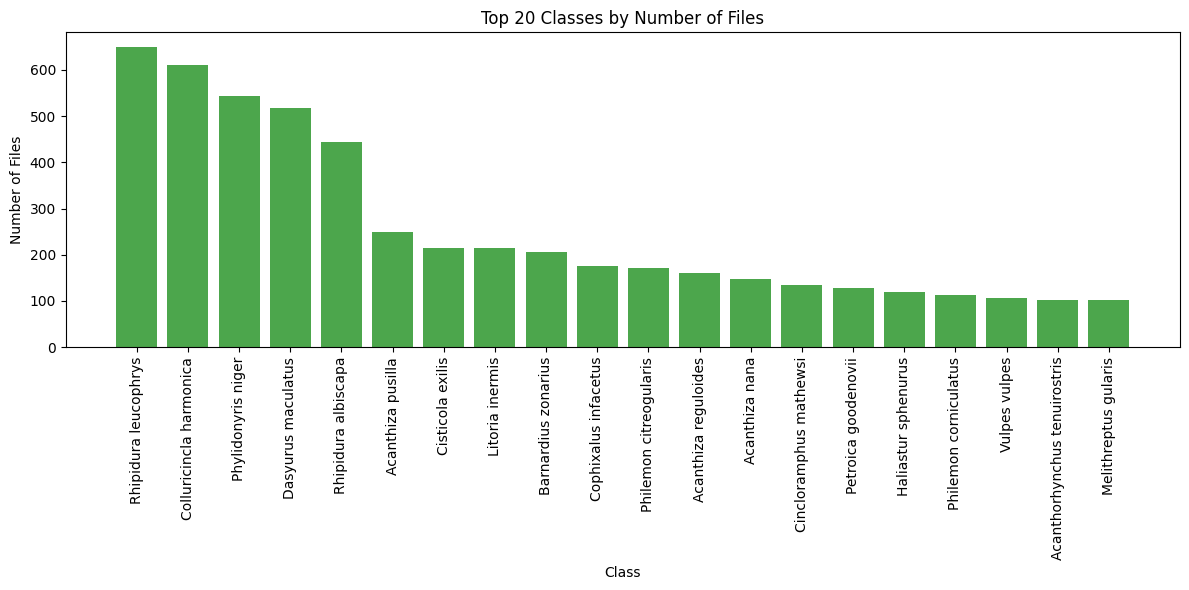

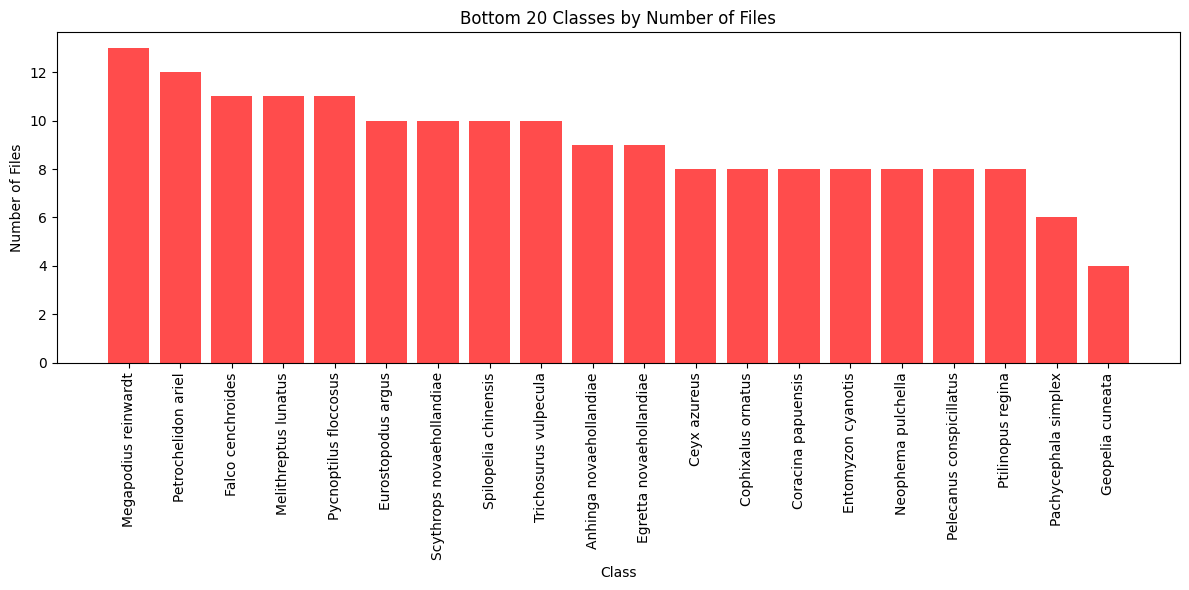


Dataset Summary:
   Total classes: 118
   Total files: 8085
   Average files per class: 68.5
   Class distribution variance: 12953.0


In [6]:
# Dataset Analysis
# This cell analyses the audio dataset and shows class distribution statistics.
# It displays the top/bottom 20 classes by file count and calculates variance.
# Backend file: /workspace/utils/visualization_tools.py (analyze_dataset_distribution function)
# 
# To modify the analysis logic, edit the analyze_dataset_distribution() function
# in /workspace/utils/visualization_tools.py

# Set the path to your audio dataset
audio_dir = "Audio_data"

# Run the analysis (function imported from utils.visualization_tools)
print("Analysing dataset distribution...")
dataset_stats = analyze_dataset_distribution(audio_dir)

print(f"\nDataset Summary:")
print(f"   Total classes: {dataset_stats['total_classes']}")
print(f"   Total files: {dataset_stats['total_files']}")
print(f"   Average files per class: {dataset_stats['mean_files']:.1f}")
print(f"   Class distribution variance: {dataset_stats['variance']:.1f}")

## 2. Configuration

Set up the directories and options for benchmarking. 

Ensure to update these in the system_config.py file in the config folder.

The default directories are as follows:

DATA_DIR = "D:\Echo\Audio_data"  # Directory containing audio data

CACHE_DIR = "D:\Echo\Training_cache"  # Directory for caching pipeline results

OUTPUT_DIR = "D:\Echo\results"  # Directory to save experiment results

In [15]:
# System Configuration
# This cell loads system directories and GPU configuration from the config files.
# It sets up paths for data, cache, and output directories, and configures GPU memory.
# Backend file: /workspace/config/system_config.py contains the SC (System Config) dictionary
#
# To modify default directories, edit the system_config.py file in the config folder.

# Import system configuration
from config.system_config import SC

# Get directory paths from system config
DATA_DIR = SC['AUDIO_DATA_DIRECTORY']
CACHE_DIR = SC['CACHE_DIRECTORY']
OUTPUT_DIR = SC['OUTPUT_DIRECTORY']

print("Using directories from system_config:")
print(f"   Data Directory: {DATA_DIR}")
print(f"   Cache Directory: {CACHE_DIR}")
print(f"   Output Directory: {OUTPUT_DIR}")

# Create output directory if it does not exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"   Created output directory: {OUTPUT_DIR}")

# GPU Configuration
print("\nGPU Configuration:")
print("   Physical GPUs:", tf.config.list_physical_devices("GPU"))
print("   Built with CUDA:", tf.test.is_built_with_cuda())
print("   GPU name:", tf.test.gpu_device_name())

# Configure GPU memory growth to avoid memory allocation issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"   GPU support enabled: {len(gpus)} GPU(s) found")
else:
    print("   No GPU support found, running on CPU")

Using directories from system_config:
   Data Directory: /workspace/Audio_data
   Cache Directory: /workspace/Training_cache
   Output Directory: /workspace/Output

GPU Configuration:
   Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
   Built with CUDA: True
   GPU name: /device:GPU:0
   GPU support enabled: 1 GPU(s) found


2025-09-16 23:30:05.028043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-16 23:30:05.028586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-16 23:30:05.028943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-16 23:30:05.029621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-16 23:30:05.029638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700] Could not ident

## 3. Available Experiments

Here you can view and select experiments to run. Each experiment represents a combination of model architecture and augmentation strategies.

In [8]:
# Available Experiments Display
# This cell displays all available experiment configurations in a table format.
# Each experiment defines a combination of model architecture and augmentation strategies.
# Backend file: /workspace/config/experiment_configs.py contains the EXPERIMENTS list
#
# To add new experiments or modify existing ones, edit experiment_configs.py

print("Available Experiments:")
print(f"   Total experiments configured: {len(EXPERIMENTS)}")

# Display experiments in a formatted table
experiment_data = []
for exp in EXPERIMENTS:
    experiment_data.append({
        "name": exp["name"],
        "model": exp["model"],
        "audio_augmentation": exp["audio_augmentation"],
        "image_augmentation": exp["image_augmentation"],
        "epochs": exp["epochs"],
        "batch_size": exp["batch_size"]
    })

experiments_df = pd.DataFrame(experiment_data)
display(experiments_df)

Available Experiments:
   Total experiments configured: 10


,name,model,audio_augmentation,image_augmentation,epochs,batch_size
0,baseline,EfficientNetV2B0,none,none,50,8
1,noise_and_stretch_audio_aug,EfficientNetV2B0,noise_and_stretch,none,10,16
2,basic_image_aug,EfficientNetV2B0,none,basic_rotation,10,16
3,full_augmentation,EfficientNetV2B0,advanced,combined,10,16
4,mobilenet_baseline,MobileNetV2,none,none,50,16
5,mobilenet_full_aug,MobileNetV2,advanced,combined,10,16
6,noise_and_pitch_small,ResNet50V2,noise_and_pitch,none,10,16
7,spec_only_aggressive,InceptionV3,none,aggressive,10,16
8,mobilenet_v3_large_baseline,MobileNetV3-Large,none,none,100,16
9,mobilenet_v3_small_baseline,MobileNetV3-Small,none,none,100,16


## 4. Interactive Experiment Selection

Use the widgets below to select experiments and set directories.

In [9]:
# Interactive Experiment Interface
# This cell creates and displays the interactive widget interface for running experiments.
# It includes directory configuration, experiment selection, and control buttons.
# Backend file: /workspace/utils/notebook_interface.py contains all widget creation functions
#
# To modify the interface layout or add new widgets, edit notebook_interface.py

print("Setting up interactive experiment interface...")

# Create the complete interface using our utility function
# This includes directory widgets, experiment selection, and action buttons
interface_components = setup_experiment_interface(
    data_dir=DATA_DIR,
    cache_dir=CACHE_DIR, 
    output_dir=OUTPUT_DIR,
    experiments=EXPERIMENTS
)

# Set up the experiment runner pipeline
# Backend file: /workspace/utils/experiment_runner.py contains the execution logic
run_experiments_pipeline(interface_components, EXPERIMENTS)

print("Interface setup complete.")
print("\nInstructions:")
print("   1. Verify or modify the directory paths above")
print("   2. Select one or more experiments from the list")
print("   3. Click 'Run Selected Experiments' to start training")
print("   4. Monitor progress in the output area below")

# Display the interface
display_experiment_interface(interface_components)

Setting up interactive experiment interface...
Interface setup complete.

Instructions:
   1. Verify or modify the directory paths above
   2. Select one or more experiments from the list
   3. Click 'Run Selected Experiments' to start training
   4. Monitor progress in the output area below


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

## 5. Experiment Runner Functions

These functions handle the execution of experiments and report generation.

In [10]:
# Experiment Execution Functions
# This cell would normally contain the complex experiment execution logic,
# but it has been moved to backend files for better organisation and maintainability.
# The functions are automatically loaded and connected to the interface above.
#
# Backend files that contain the execution logic:
# - /workspace/utils/experiment_runner.py: Main experiment execution and orchestration
# - /workspace/utils/optimised_engine_pipeline.py: Model training pipeline
# - /workspace/utils/data_pipeline.py: Data loading and preprocessing
# - /workspace/utils/visualization_tools.py: Performance analysis and visualisation
# - /workspace/utils/metadata_handler.py: Results saving and metadata management
#
# To modify experiment execution logic, edit the files listed above.
# The experiment runner is already connected to the "Run Selected Experiments" button.

print("Experiment execution functions loaded from backend files.")
print("Functions are connected to the interface buttons above.")
print("\nBackend files containing execution logic:")
print("   experiment_runner.py - Main execution orchestration")
print("   optimised_engine_pipeline.py - Model training pipeline") 
print("   data_pipeline.py - Data loading and preprocessing")
print("   visualization_tools.py - Performance analysis")
print("\nClick 'Run Selected Experiments' above to start training.")

Experiment execution functions loaded from backend files.
Functions are connected to the interface buttons above.

Backend files containing execution logic:
   experiment_runner.py - Main execution orchestration
   optimised_engine_pipeline.py - Model training pipeline
   data_pipeline.py - Data loading and preprocessing
   visualization_tools.py - Performance analysis

Click 'Run Selected Experiments' above to start training.


## 6. View Previous Results (From here down, notebook is under development)

If you've already run experiments, you can view and analyse the results here.

In [18]:
# Load Previous Results
# This cell loads and displays results from previously completed experiments.
# It looks for metadata.json files in the output/models directory and creates a comprehensive table.
# Backend file: /workspace/utils/visualization_tools.py (load_results function)
#
# To modify how results are loaded or displayed, edit the load_results() function

print("Loading previous experiment results...")

# Force reload the module to pick up changes
import importlib
import utils.visualization_tools
importlib.reload(utils.visualization_tools)
from utils.visualization_tools import load_results

# Load results using the utility function
results_df = load_results(OUTPUT_DIR)

# Display results if found
if results_df is not None:
    print(f"Found results with {len(results_df)} experiments.")
    print("\nExperiment Results Summary:")
    
    # Create a copy for display without timestamp column
    display_df = results_df.drop(columns=['Timestamp'], errors='ignore')
    
    # Display as HTML table with clickable links
    from IPython.display import HTML
    html_table = display_df.to_html(escape=False, index=False, table_id="results_table")
    
    # Add some CSS styling
    styled_html = f"""
    <style>
    #results_table {{
        border-collapse: collapse;
        margin: 25px 0;
        font-size: 0.9em;
        font-family: sans-serif;
        min-width: 400px;
        box-shadow: 0 0 20px rgba(0, 0, 0, 0.15);
    }}
    #results_table thead tr {{
        background-color: #009879;
        color: #ffffff;
        text-align: left;
    }}
    #results_table th,
    #results_table td {{
        padding: 12px 15px;
        border: 1px solid #dddddd;
    }}
    #results_table tbody tr {{
        border-bottom: 1px solid #dddddd;
    }}
    #results_table tbody tr:nth-of-type(even) {{
        background-color: #f3f3f3;
    }}
    #results_table a {{
        color: #009879;
        text-decoration: none;
        font-weight: bold;
    }}
    #results_table a:hover {{
        text-decoration: underline;
    }}
    </style>
    {html_table}
    """
    
    display(HTML(styled_html))
    
    # Also display the raw DataFrame for programmatic access
    print("\nRaw DataFrame (for further analysis):")
    display(results_df)
    
else:
    print("No previous results found. Run some experiments first.")
    print(f"   Results will be saved to: {OUTPUT_DIR}/models/")
    print("   After running experiments, re-run this cell to see results.")

Loading previous experiment results...
Loaded 2 experiment results from metadata files
Found results with 2 experiments.

Experiment Results Summary:


Experiment,Model,Accuracy,Precision,Recall,F1 Score,Training Time (min),Audio Aug,Image Aug,Performance Analysis,Confusion Analysis
mobilenet_v3_large_baseline,MobileNetV3-Large,0.8055,0.8120,0.7704,0.7584,34.1,none,none,Performance Analysis,Confusion Analysis
mobilenet_v3_large_baseline,MobileNetV3-Large,0.7830,0.7047,0.7001,0.6821,28.4,none,none,,



Raw DataFrame (for further analysis):


,Experiment,Model,Accuracy,Precision,Recall,F1 Score,Training Time (min),Audio Aug,Image Aug,Performance Analysis,Confusion Analysis,Timestamp
1,mobilenet_v3_large_baseline,MobileNetV3-Large,0.8055,0.8120,0.7704,0.7584,34.1,none,none,"<a href=""/workspace/Output/models/mobilenet_v3...","<a href=""/workspace/Output/models/mobilenet_v3...",20250915_014604
0,mobilenet_v3_large_baseline,MobileNetV3-Large,0.7830,0.7047,0.7001,0.6821,28.4,none,none,,,20250910_005207
